In [ ]:
import pandas as pd
import time
import calendar
from io import StringIO

# --- CONFIGURACIÓN ---
cols_esperadas = [
    'Province_State', 'Country_Region', 'Last_Update', 'Lat', 'Long_',
    'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key',
    'Incident_Rate', 'Case_Fatality_Ratio'
]

# mapeo de variantes de nombres de columnas a la forma "normalizada"
col_map_variantes = {
    'province/state': 'province_state',
    'province_state': 'province_state',
    'province': 'province_state',
    'country/region': 'country_region',
    'country_region': 'country_region',
    'countryregion': 'country_region',
    'last update': 'last_update',
    'last_update': 'last_update',
    'lastupdate': 'last_update',
    'long_': 'long_',
    'longitude': 'long_',
    'long': 'long_',
    'lat': 'lat',
    'confirmed': 'confirmed',
    'deaths': 'deaths',
    'recovered': 'recovered',
    'active': 'active',
    'combined_key': 'combined_key',
    'incident_rate': 'incident_rate',
    'case_fatality_ratio': 'case_fatality_ratio'
}


anio_inicio = 2021
anio_fin = 2022

base_url = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/"
            "refs/heads/master/csse_covid_19_data/csse_covid_19_daily_reports")

# lista para registrar URLs fallidas y log por archivo
urls_fallidas = []
log_filas = []

def normalizar_columnas(df):
    # normalizamos nombres: lower, quitar espacios, slash -> _
    cols = list(df.columns)
    cols_low = [c.lower().strip().replace(' ', '_').replace('/', '_') for c in cols]
    df.columns = cols_low
    # mapeo a nombres esperados
    new_cols = {}
    for c in df.columns:
        key = c.lower()
        if key in col_map_variantes:
            new_cols[c] = col_map_variantes[key]
        else:
            # intentar quitar sufijos/prefijos comunes
            c_clean = key.replace(' ', '_').replace('/', '_')
            if c_clean in col_map_variantes:
                new_cols[c] = col_map_variantes[c_clean]
            else:
                new_cols[c] = c  # dejar tal cual si no se reconoce
    df = df.rename(columns=new_cols)
    return df

def intentar_leer(url):
    """Intentos de lectura tolerantes. Devuelve DataFrame o None."""
    # 1) Intento rápido con usecols y dtypes (rápido cuando coincide)
    try:
        df = pd.read_csv(url, usecols=cols_esperadas)
        df = normalizar_columnas(df)
        return df
    except Exception:
        pass
    # 2) Intento leer todo y luego seleccionar/norm
    try:
        df = pd.read_csv(url, low_memory=False)
        df = normalizar_columnas(df)
        return df
    except Exception:
        pass
    # 3) Intento con engine='python' y diferentes encodings (alta tolerancia)
    encodings = ['utf-8', 'latin1', 'iso-8859-1']
    for enc in encodings:
        try:
            df = pd.read_csv(url, engine='python', encoding=enc, error_bad_lines=False)  # noqa: E712
            df = normalizar_columnas(df)
            return df
        except Exception:
            continue
    # 4) intentamos leer como texto y parsear por si hay BOMs u otras rarezas
    try:
        import requests
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        txt = resp.text
        df = pd.read_csv(StringIO(txt), low_memory=False)
        df = normalizar_columnas(df)
        return df
    except Exception:
        pass
    return None

def iterar_diarios_tolerante(anio_inicio, anio_fin):
    for anio in range(anio_inicio, anio_fin + 1):
        for mes in range(1, 13):
            dias_en_mes = calendar.monthrange(anio, mes)[1]
            mes_s = f"{mes:02d}"
            for dia in range(1, dias_en_mes + 1):
                dia_s = f"{dia:02d}"
                url = f"{base_url}/{mes_s}-{dia_s}-{anio}.csv"
                df = intentar_leer(url)
                if df is None:
                    urls_fallidas.append(url)
                    log_filas.append({
                        'url': url, 'anio': anio, 'mes': mes, 'dia': dia,
                        'ok': False, 'nrows': 0
                    })
                    continue
                # Añadimos columna de fecha fuente para debugging
                df['source_date'] = f"{anio}-{mes_s}-{dia_s}"
                log_filas.append({
                    'url': url, 'anio': anio, 'mes': mes, 'dia': dia,
                    'ok': True, 'nrows': len(df)
                })
                # Aseguramos que contenga al menos las columnas principales con nombres normalizados
                # (las que falten se crearán más tarde)
                yield df

# --- EJECUCIÓN robusta ---
start = time.time()
iterador = iterar_diarios_tolerante(anio_inicio, anio_fin)
lista_chunks = list(iterador)  # aquí cargamos todos los DataFrames exitosos
if lista_chunks:
    covid_anuales = pd.concat(lista_chunks, ignore_index=True)
else:
    covid_anuales = pd.DataFrame()

# --- LOG Y LIMPIEZA FINAL ---
log_procesos = pd.DataFrame(log_filas)
print("Archivos leídos OK:", log_procesos['ok'].sum(), "  Fallidos:", len(log_procesos) - log_procesos['ok'].sum())
print(f"Tiempo total lectura: {time.time() - start:.2f} seg")

# Normalización final de nombres (asegurar columnas en minúscula con _)
covid_anuales.columns = [c.lower() for c in covid_anuales.columns]

# Rellenar columnas esperadas si faltan (con NaN / 0 luego)
for expected in ['province_state','country_region','last_update','lat','long_',
                 'confirmed','deaths','recovered','active','combined_key',
                 'incident_rate','case_fatality_ratio']:
    if expected not in covid_anuales.columns:
        covid_anuales[expected] = pd.NA

# Conversions
covid_anuales['last_update'] = pd.to_datetime(covid_anuales['last_update'], errors='coerce')
# Categoricals
for col in ['country_region', 'province_state']:
    covid_anuales[col] = covid_anuales[col].astype('category')

# Numéricos: intentar convertir a int si procede
for c in ['confirmed','deaths','recovered','active','incident_rate','case_fatality_ratio']:
    if c in covid_anuales.columns:
        # primero reemplazar strings vacíos por NaN
        covid_anuales[c] = pd.to_numeric(covid_anuales[c], errors='coerce')
# Llenar NaNs y convertir counts a enteros
for c in ['confirmed','deaths','recovered','active']:
    if c in covid_anuales.columns:
        covid_anuales[c] = covid_anuales[c].fillna(0).astype('int64')

# Columna calculada
if all(x in covid_anuales.columns for x in ['confirmed', 'deaths', 'recovered']):
    covid_anuales['active_cases'] = (
        covid_anuales['confirmed'] - covid_anuales['deaths'] - covid_anuales['recovered']
    )

# Mostrar resumen y primeras filas
display(log_procesos.head(20))
print("URLs fallidas (ejemplos):", urls_fallidas[:10])
display(covid_anuales.head())

# Guardar csvs de log si quieres revisar fuera de python:
# log_procesos.to_csv('log_procesos.csv', index=False)
# pd.DataFrame({'failed_urls': urls_fallidas}).to_csv('urls_fallidas.csv', index=False)


Archivos leídos OK: 730   Fallidos: 0
Tiempo total lectura: 263.66 seg


,url,anio,mes,dia,ok,nrows
0,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,1,True,4011
1,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,2,True,4011
2,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,3,True,4012
3,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,4,True,4012
4,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,5,True,4012
5,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,6,True,4012
6,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,7,True,4012
7,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,8,True,4012
8,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,9,True,4012
9,https://raw.githubusercontent.com/CSSEGISandDa...,2021,1,10,True,4012


URLs fallidas (ejemplos): []


,province_state,country_region,last_update,lat,long_,confirmed,deaths,recovered,active,combined_key,incident_rate,case_fatality_ratio,source_date,active_cases
0,NaN,Afghanistan,2021-01-02 05:22:33,33.93911,67.709953,52513,2201,41727,8585,Afghanistan,134.896576,4.191343,2021-01-01,8585
1,NaN,Albania,2021-01-02 05:22:33,41.15330,20.168300,58316,1181,33634,23501,Albania,2026.409058,2.025173,2021-01-01,23501
2,NaN,Algeria,2021-01-02 05:22:33,28.03390,1.659600,99897,2762,67395,29740,Algeria,227.809860,2.764848,2021-01-01,29740
3,NaN,Andorra,2021-01-02 05:22:33,42.50630,1.521800,8117,84,7463,570,Andorra,10505.403320,1.034865,2021-01-01,570
4,NaN,Angola,2021-01-02 05:22:33,-11.20270,17.873900,17568,405,11146,6017,Angola,53.452980,2.305328,2021-01-01,6017


In [5]:
covid_anuales.shape

(2931108, 13)

In [1]:
#PARTE 3
#CARGAR DATOS
import pandas as pd
covid_anuales = pd.DataFrame()
for anio in range(2021,2023):
  for j in range(1,13):
    mes = f"{j:02d}"
    for i in range(1,32):
      dia = f"{i:02d}"
      download_url = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_daily_reports/{mes}-{dia}-{anio}.csv"
      try:
        aux = pd.read_csv(download_url)
        covid_anuales = pd.concat([covid_anuales,aux],ignore_index=True)
        print(f'{dia}-{mes}-{anio} Descargado Correctamente')
      except Exception as e:
        print(f"El mes {mes} no tiene {dia} dias en el año {anio}")

01-01-2021 Descargado Correctamente
02-01-2021 Descargado Correctamente
03-01-2021 Descargado Correctamente
04-01-2021 Descargado Correctamente
05-01-2021 Descargado Correctamente
06-01-2021 Descargado Correctamente
07-01-2021 Descargado Correctamente
08-01-2021 Descargado Correctamente
09-01-2021 Descargado Correctamente
10-01-2021 Descargado Correctamente
11-01-2021 Descargado Correctamente
12-01-2021 Descargado Correctamente
13-01-2021 Descargado Correctamente
14-01-2021 Descargado Correctamente
15-01-2021 Descargado Correctamente
16-01-2021 Descargado Correctamente
17-01-2021 Descargado Correctamente
18-01-2021 Descargado Correctamente
19-01-2021 Descargado Correctamente
20-01-2021 Descargado Correctamente
21-01-2021 Descargado Correctamente
22-01-2021 Descargado Correctamente
23-01-2021 Descargado Correctamente
24-01-2021 Descargado Correctamente
25-01-2021 Descargado Correctamente
26-01-2021 Descargado Correctamente
27-01-2021 Descargado Correctamente
28-01-2021 Descargado Correc

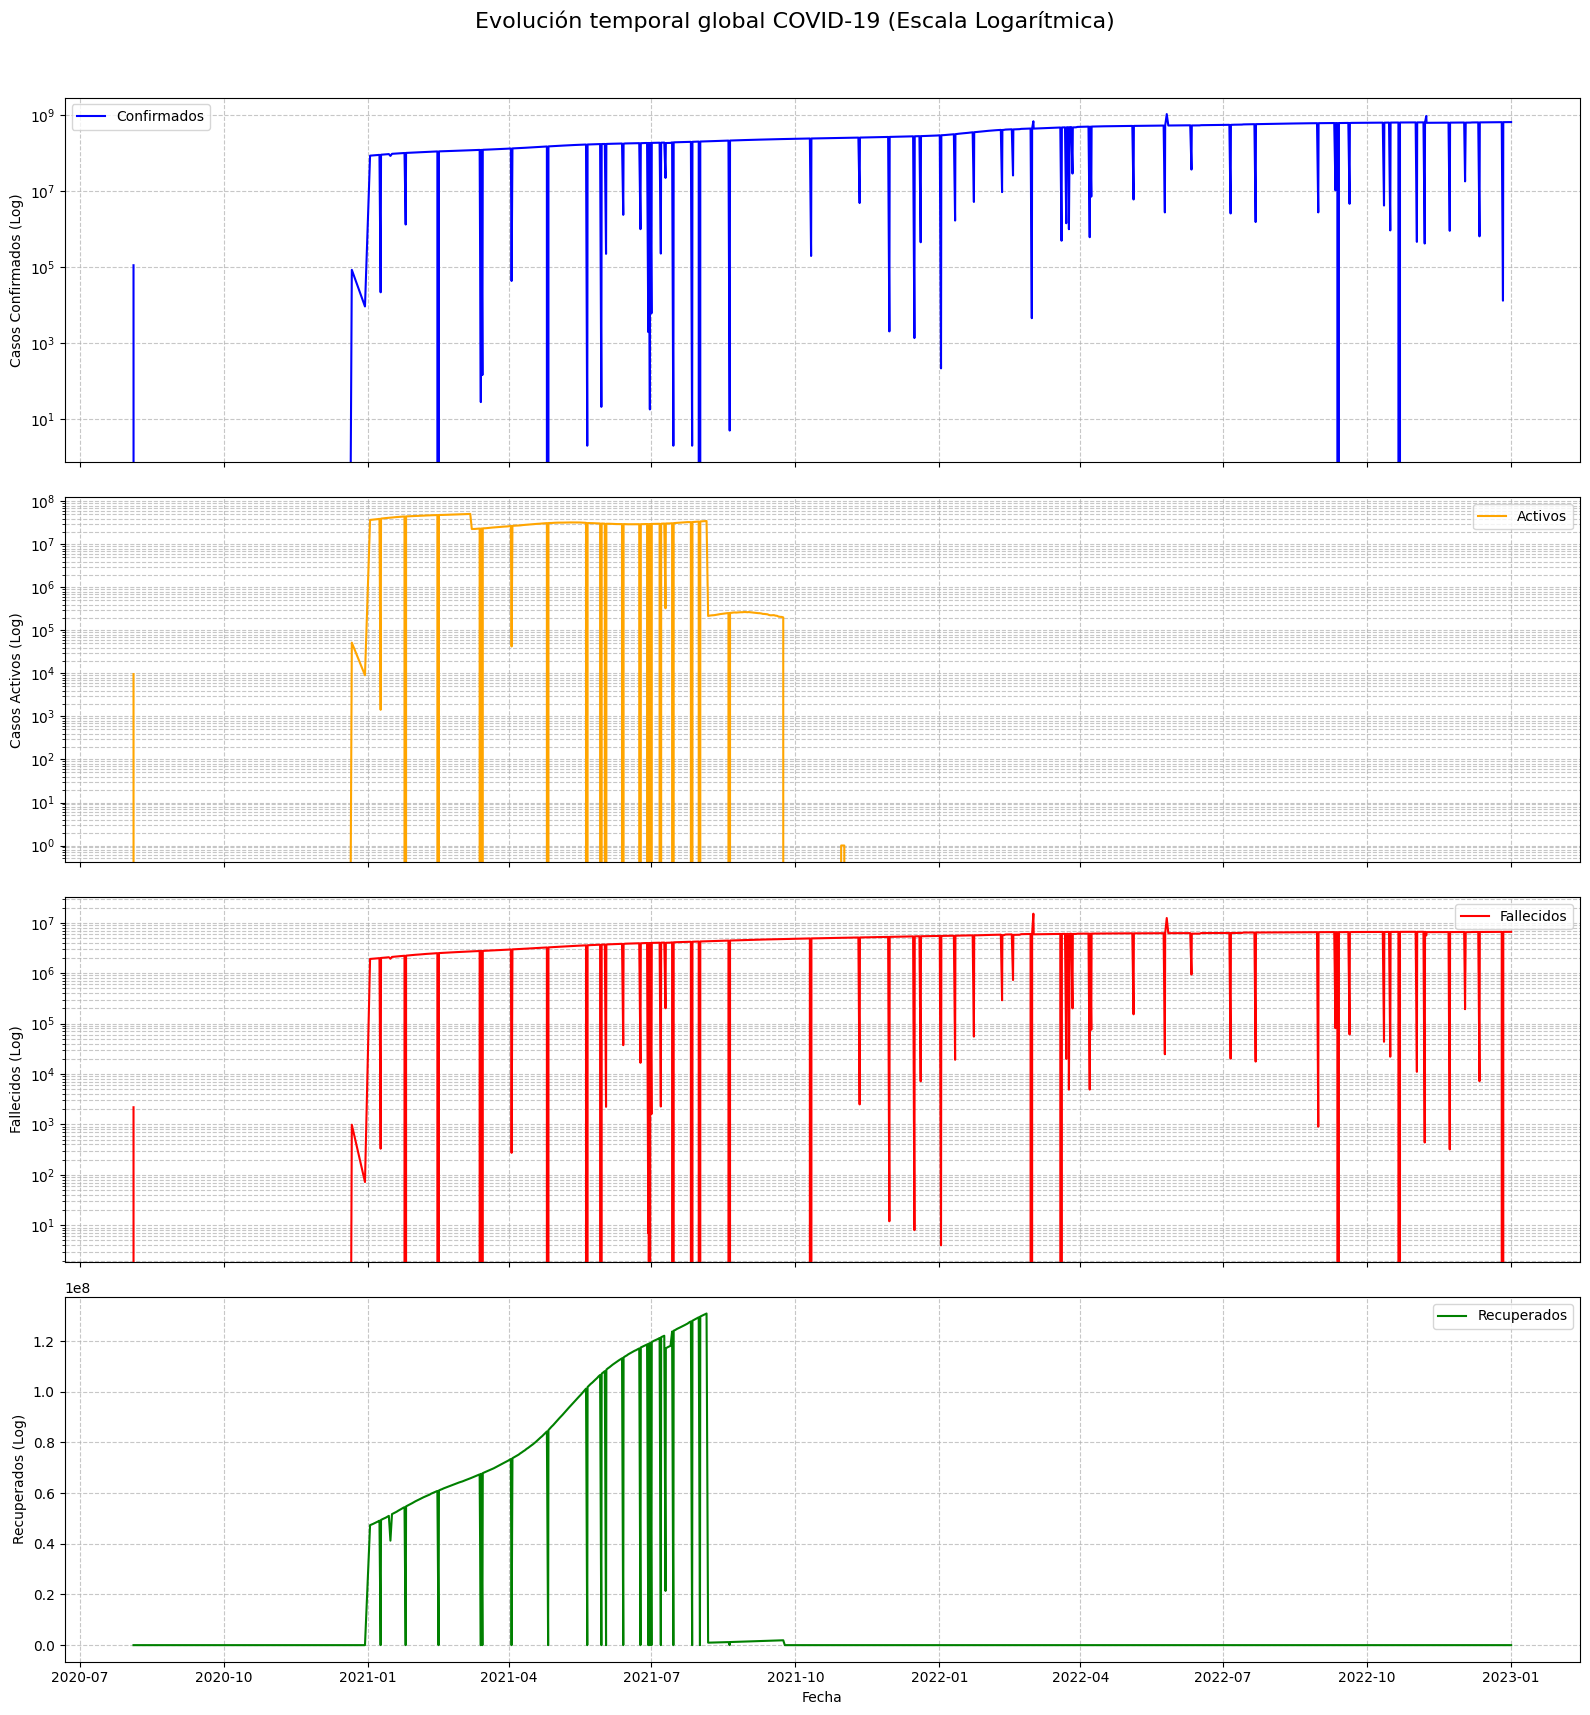

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import glob


global_daily = covid_anuales.groupby("last_update")[["confirmed", "deaths", "recovered", "active"]].sum()

fig, axes = plt.subplots(4, 1, figsize=(16, 18), sharex=True)
fig.suptitle("Evolución temporal global COVID-19 (Escala Logarítmica)", fontsize=16)

axes[0].plot(global_daily.index, global_daily["confirmed"], label="Confirmados", color='blue')
axes[0].set_ylabel("Casos Confirmados (Log)")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True, which="both", linestyle="--", alpha=0.7)

axes[1].plot(global_daily.index, global_daily["active"], label="Activos", color='orange')
axes[1].set_ylabel("Casos Activos (Log)")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].grid(True, which="both", linestyle="--", alpha=0.7)

axes[2].plot(global_daily.index, global_daily["deaths"], label="Fallecidos", color='red')
axes[2].set_ylabel("Fallecidos (Log)")
axes[2].set_yscale("log")
axes[2].legend()
axes[2].grid(True, which="both", linestyle="--", alpha=0.7)

axes[3].plot(global_daily.index, global_daily["recovered"], label="Recuperados", color='green')
axes[3].set_ylabel("Recuperados (Log)")
axes[3].set_xlabel("Fecha")
axes[3].legend()
axes[3].grid(True, which="both", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_15876\2728115301.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top10 = covid_anuales.groupby("country_region")["confirmed"].sum().sort_values(ascending=False).head(10)


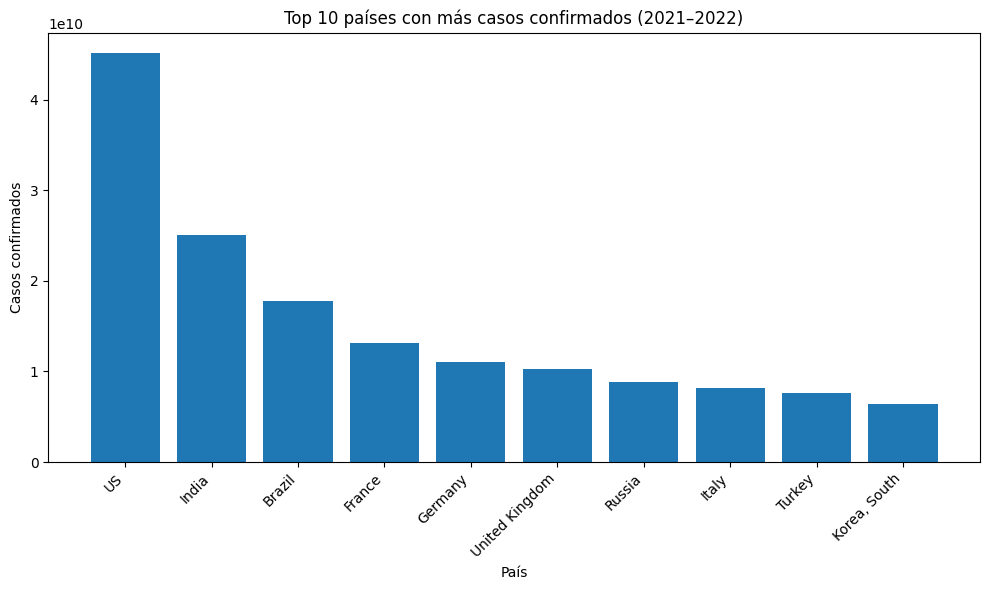

In [11]:
#2. Comparativa Top 10 países con más casos confirmados (barras).
top10 = covid_anuales.groupby("country_region")["confirmed"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10.index, top10.values)
plt.xticks(rotation=45, ha="right")

plt.title("Top 10 países con más casos confirmados (2021–2022)")
plt.xlabel("País")
plt.ylabel("Casos confirmados")
plt.tight_layout()
plt.show()

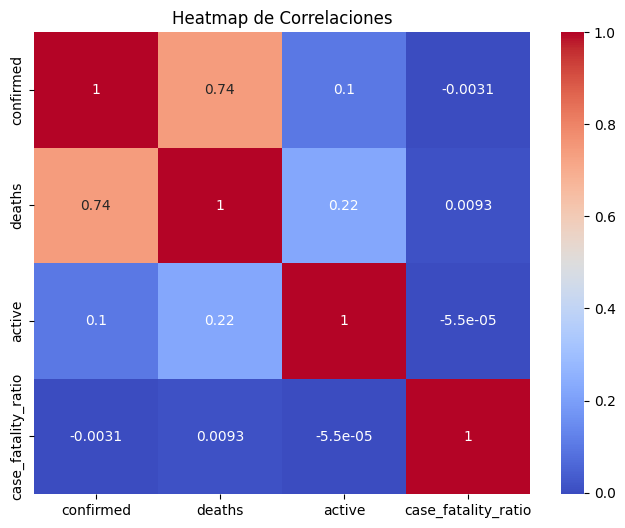

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

columnas_relevantes = ['confirmed', 'deaths', 'active', 'case_fatality_ratio']

correlationes = covid_anuales[columnas_relevantes].dropna()

matriz_corr = correlationes.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlaciones')
plt.show()

In [ ]:
%pip install country_converter

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import country_converter as coco
# import warnings
# import logging # <--- Necesario para controlar los logs

# # 1. CONFIGURACIÓN PARA SILENCIAR EL RUIDO
# # Silenciar warnings de Pandas/Python
# warnings.filterwarnings('ignore')

# # SILENCIAR WARNINGS DE COUNTRY_CONVERTER (Esta es la parte clave)
# # Le decimos al logger de 'country_converter' que solo nos avise si hay ERRORES graves,
# # ignorando las advertencias (WARNINGS) de "not found".
# logging.getLogger('country_converter').setLevel(logging.ERROR)

# # --- Tu código de procesamiento ---

# # Estandarizar nombres de países para consistencia
# country_name_standardization = {
#     "US": "United States",
#     "Korea, North": "North Korea",
#     "Korea, South": "South Korea",
#     "Taiwan*": "Taiwan"
# }

# # Asumiendo que 'covid_anuales' ya está cargado anteriormente.
# # Si no, asegúrate de tener el dataframe cargado antes de este punto.
# # Ejemplo: covid_anuales = pd.read_csv(...)

# covid_anuales['Country_Region'] = covid_anuales['Country_Region'].replace(country_name_standardization)

# # Asegurarse de que 'Case_Fatality_Ratio' es numérico y manejar valores no válidos
# covid_anuales['Case_Fatality_Ratio'] = pd.to_numeric(covid_anuales['Case_Fatality_Ratio'], errors='coerce')

# # Usar country_converter para obtener los continentes
# # Al haber silenciado el logger arriba, el parámetro not_found=None funcionará silenciosamente
# if 'Continent' not in covid_anuales.columns or (covid_anuales['Continent'] == 'Other').sum() > len(covid_anuales) * 0.05:
#     covid_anuales['Continent'] = coco.convert(names=covid_anuales['Country_Region'], to='continent', not_found=None)
#     covid_anuales['Continent'] = covid_anuales['Continent'].fillna('Other')
# else:
#     pass

# # Calcular la media de la tasa de letalidad por continente, excluyendo NaN
# lethal_rate_by_continent = covid_anuales.groupby('Continent')['Case_Fatality_Ratio'].mean().dropna().sort_values(ascending=False)

# # Crear el gráfico de barras horizontales
# plt.figure(figsize=(12, 8))
# lethal_rate_by_continent.plot(kind='barh', color='skyblue')
# plt.title('Tasa de Letalidad Promedio por Continente (2021-2022)')
# plt.xlabel('Tasa de Letalidad Promedio (%)')
# plt.ylabel('Continente')
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

Conversión terminada.


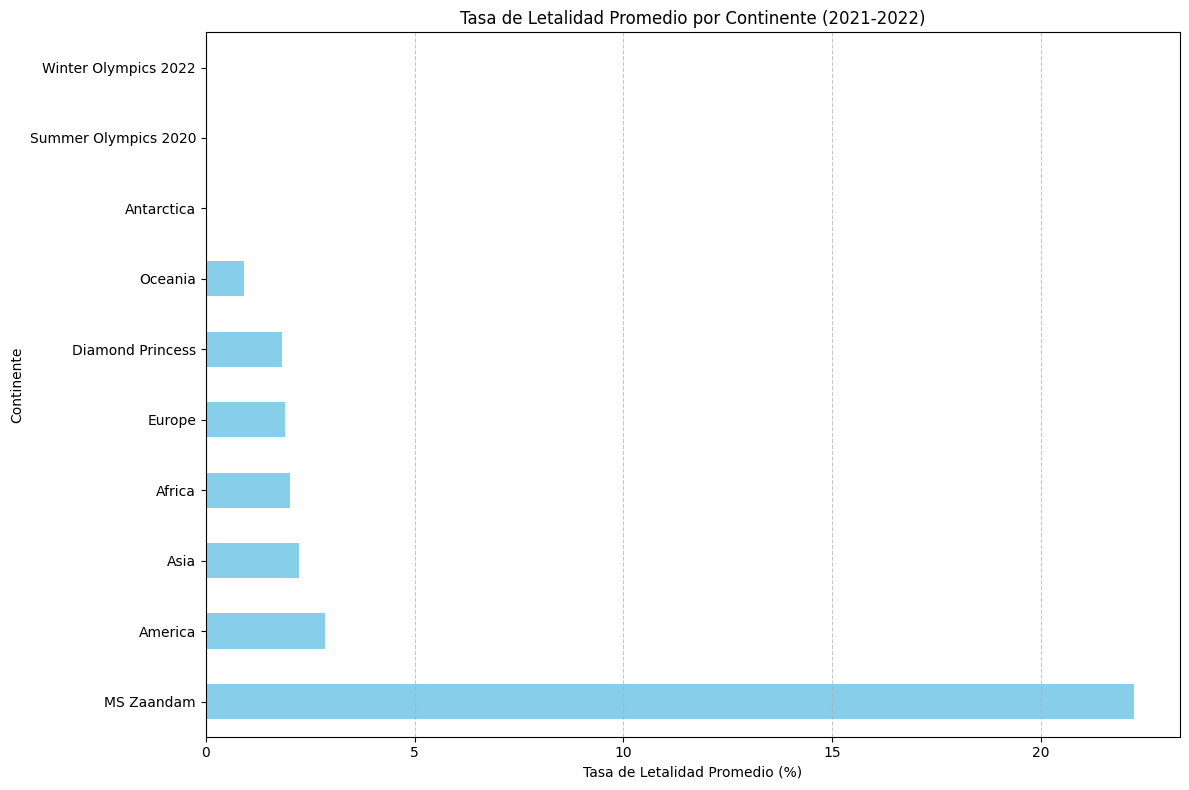

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import country_converter as coco
import warnings
import logging

# 1. CONFIGURACIÓN DE SILENCIO (Igual que antes)
warnings.filterwarnings('ignore')
logging.getLogger('country_converter').setLevel(logging.ERROR)

# --- Procesamiento Optimizado ---

# Estandarizar nombres
country_name_standardization = {
    "US": "United States",
    "Korea, North": "North Korea",
    "Korea, South": "South Korea",
    "Taiwan*": "Taiwan"
}
# Asumiendo que covid_anuales ya está cargado
covid_anuales['Country_Region'] = covid_anuales['Country_Region'].replace(country_name_standardization)
covid_anuales['Case_Fatality_Ratio'] = pd.to_numeric(covid_anuales['Case_Fatality_Ratio'], errors='coerce')

# 2. EL TRUCO DE VELOCIDAD: Mapeo de Únicos
if 'Continent' not in covid_anuales.columns or (covid_anuales['Continent'] == 'Other').sum() > len(covid_anuales) * 0.05:
    # Paso A: Obtener solo los nombres únicos de países (son pocos, ~200)
    unique_countries = covid_anuales['Country_Region'].unique()

    # Paso B: Convertir solo esa lista pequeña (esto tarda milisegundos)
    # Usamos src='regex' por defecto, o dejamos que la librería adivine
    continents_list = coco.convert(names=unique_countries, to='continent', not_found=None)

    # Paso C: Crear un diccionario {País: Continente}
    country_to_continent_map = dict(zip(unique_countries, continents_list))

    # Paso D: Aplicar el diccionario a la columna entera (Pandas hace esto instantáneo)
    covid_anuales['Continent'] = covid_anuales['Country_Region'].map(country_to_continent_map)

    # Rellenar nulos
    covid_anuales['Continent'] = covid_anuales['Continent'].fillna('Other')

    print("Conversión terminada.")

# 3. GRAFICAR
lethal_rate_by_continent = covid_anuales.groupby('Continent')['Case_Fatality_Ratio'].mean().dropna().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
lethal_rate_by_continent.plot(kind='barh', color='skyblue')
plt.title('Tasa de Letalidad Promedio por Continente (2021-2022)')
plt.xlabel('Tasa de Letalidad Promedio (%)')
plt.ylabel('Continente')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
#5. Mapa o gráfico geográfico que muestre la incidencia por continente o país (opcional).

import plotly.express as px


covid_anuales.dropna(subset=['Last_Update'], inplace=True)

latest_data = covid_anuales.sort_values('Last_Update').drop_duplicates(subset=['Country_Region'], keep='last')

confirmed_cases_by_country = latest_data.groupby('Country_Region')['Confirmed'].sum().reset_index()

fig = px.choropleth(
    confirmed_cases_by_country,
    locations='Country_Region',
    locationmode='country names',
    color='Confirmed',
    hover_name='Country_Region',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Casos de covid confirmados por pais'
    )

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [2]:
# --- Al final de tu código de la Parte 3 ---

# Guardamos el archivo listo para que el Dashboard lo pueda leer
print("Guardando archivo para el Dashboard...")
covid_anuales.to_csv('covid_final_dashboard.csv', index=False)
print("¡Archivo 'covid_final_dashboard.csv' guardado con éxito!")

Guardando archivo para el Dashboard...
¡Archivo 'covid_final_dashboard.csv' guardado con éxito!
